## Importing the Relevant Libraries
- These might not be the only ones necessary. 
- Will update libraries as we go.

In [54]:
import numpy as np # forlinear algebra
import matplotlib.pyplot as plt #for plotting things
import os
from PIL import Image
print(os.listdir("../rscbjbr9sj-2"))
import tensorflow as tf

# Keras Libraries
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.metrics import classification_report, confusion_matrix

['ChestXRay.ipynb', '.DS_Store', 'chest_xray', '.ipynb_checkpoints']


In [55]:
ls

ChestXRay.ipynb  chest_xray/


## Loading up the Chest X-Ray Data
- Setting up the location of the:
 1. Train set
 2. Test set
 3. The validation set

In [56]:
mainDIR = os.listdir('chest_xray/')
print(mainDIR)

['.DS_Store', 'test', 'chest_xray', '__MACOSX', 'train', 'val']


In [57]:
train_folder = 'chest_xray/train/'
val_folder = 'chest_xray/val/'
test_folder = 'chest_xray/test/'

In [58]:
type(train_p)


str

In [59]:
# train 
os.listdir(train_folder)
train_n = train_folder+'NORMAL/'
train_p = train_folder+'PNEUMONIA/'

1341
normal picture title:  IM-0325-0001.jpeg
pneumonia picture title: person374_bacteria_1712.jpeg


Text(0.5, 1.0, 'Pneumonia')

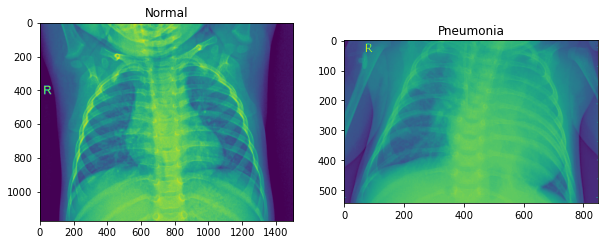

In [60]:
#Normal pic 
print(len(os.listdir(train_n)))
rand_norm= np.random.randint(0,len(os.listdir(train_n)))
norm_pic = os.listdir(train_n)[rand_norm]
print('normal picture title: ',norm_pic)

norm_pic_address = train_n+norm_pic

#Pneumonia
rand_p = np.random.randint(0,len(os.listdir(train_p)))

sic_pic =  os.listdir(train_p)[rand_norm]
sic_address = train_p+sic_pic
print('pneumonia picture title:', sic_pic)

# Load the images
norm_load = Image.open(norm_pic_address)
sic_load = Image.open(sic_address)

#Let's plt these images
f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(norm_load)
a1.set_title('Normal')

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(sic_load)
a2.set_title('Pneumonia')

In [61]:
# let's build the CNN model

cnn = Sequential()

#Convolution
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 3)))

#Pooling
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd Convolution
cnn.add(Conv2D(32, (3, 3), activation="relu"))

# 2nd Pooling layer
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Flatten the layer
cnn.add(Flatten())

# Fully Connected Layers
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'sigmoid', units = 1))

# Compile the Neural network
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [62]:
num_of_test_samples = 600
batch_size = 32

In [63]:
# Fitting the CNN to the images
# The function ImageDataGenerator augments your image by iterating through image as your CNN is getting ready to process that image

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)  #Image normalization.

training_set = train_datagen.flow_from_directory('chest_xray/train/',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory('chest_xray/val/',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary')

test_set = test_datagen.flow_from_directory('chest_xray/test/',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [64]:
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [65]:
cnn_model = cnn.fit_generator(training_set,
                         steps_per_epoch = 163,
                         epochs = 1,
                         validation_data = validation_generator,
                         validation_steps = 624)

163/163 [==============================] - 60s 366ms/step - loss: 0.3446 - accuracy: 0.8484 - val_loss: 1.2796 - val_accuracy: 0.6250


In [66]:
test_accu = cnn.evaluate_generator(test_set,steps=624)

In [67]:
print('The testing accuracy is :',test_accu[1]*100, '%')

The testing accuracy is : 71.47436141967773 %
